Les rédactions de [Rue89 Strasbourg](https://www.rue89strasbourg.com/legislatives-2022-alsace-carte-candidats-233964), [Rue89 Lyon](https://www.rue89lyon.fr/2022/05/23/legislatives-lyon-rhone-candidats-carte-liste/) et [Marsactu](https://marsactu.fr/legislatives-200-candidatures-et-quelques-surprises/) ont récemment publié des **cartographies présentant les candidats aux prochaines législatives**. 

Ce tir groupé a été l'occasion de recycler un [travail consacré aux élections départementales de 2021](https://github.com/raphadasilva/blog_rdasilva/blob/master/autodonnees/departementales2021_alsace/D%C3%A9partementales%202021%20-%20Jointures%2C%20groupby%20et%20apply%20avec%20pandas.ipynb). Il est intéressant comme cas d'école de manipulation de données géographiques, augmentées ensuite par des données tabulaires.

![leg022_marsactu](leg022_marsactu.jpg)

Ce calepin centré sur Marseille et les Bouches-du-Rhône va suivre scrupuleusement ces deux étapes, et impliquera les modules Python suivants :

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Préparation des fichiers géographiques

## Sélections et redécoupages

Le cahier des charges discutés avec les trois rédactions était le suivant :
* **distinguer les communes** des départements retenus **par circonscription législative**, pour qu'au survol on isole la composition de chaque circo. Dans les cas de Lyon et Marseille, cela inclut également les arrondissements de la grande ville
* **lier à chaque circonscription une liste de candidats** avec quelques informations d'état civil

On va commencer par importer un premier fichier géographique, [avec les contours communaux de France fournis par OpenStreetMap](https://www.data.gouv.fr/fr/datasets/decoupage-administratif-communal-francais-issu-d-openstreetmap/) sur le portail Datagouv :

In [2]:
communes=gpd.read_file(r"https://www.data.gouv.fr/fr/datasets/r/0e117c06-248f-45e5-8945-0e79d9136165")
communes.tail()

,insee,nom,wikipedia,surf_ha,geometry
34950,80122,Bouquemaison,fr:Bouquemaison,724.0,"POLYGON ((2.31459 50.23489, 2.31746 50.23535, ..."
34951,62795,Sibiville,fr:Sibiville,738.0,"POLYGON ((2.30945 50.31902, 2.30969 50.31913, ..."
34952,62694,Rebreuve-sur-Canche,fr:Rebreuve-sur-Canche,842.0,"POLYGON ((2.32074 50.24767, 2.32077 50.24771, ..."
34953,62831,Troisvaux,fr:Troisvaux,620.0,"POLYGON ((2.32046 50.40520, 2.32137 50.40571, ..."
34954,62187,Buneville,fr:Buneville,384.0,"POLYGON ((2.32947 50.32125, 2.32956 50.32174, ..."


Seulement cinq colonnes, mais dont on ne peut finalement retenir que **les codes INSEE, les noms de commune ainsi que la géométrie**.

On va également ne retenir que les enregistrements **dont le code INSEE commence par le code départemental des Bouches-du-Rhône** ("13") dans une nouvelle variable.

Première précaution avant de tailler : faire une copie de la GeoDataFrame communes. Cela évitera d'avoir à recharger le lourd fichier OSM si jamais on fait une fausse manipulation.

In [3]:
combdr=communes.copy()
combdr=combdr[["insee","nom","geometry"]]
combdr=combdr[combdr["insee"].astype(str).str.slice(start=0,stop=2).isin(["13"])].reset_index(drop=True)
combdr["insee"]=combdr["insee"].astype(str)
combdr.tail()

,insee,nom,geometry
114,13072,Peynier,"POLYGON ((5.58757 43.44272, 5.58875 43.44513, ..."
115,13007,Auriol,"POLYGON ((5.60689 43.37052, 5.60692 43.37061, ..."
116,13016,La Bouilladisse,"POLYGON ((5.58188 43.40492, 5.58223 43.40497, ..."
117,13086,Roquevaire,"POLYGON ((5.54614 43.34455, 5.54841 43.34434, ..."
118,13110,Trets,"POLYGON ((5.63905 43.40411, 5.64223 43.40822, ..."


On peut par précaution visualiser la GeoDataFrame combdr afin de s'assurer que les communes retenues sont bien au conforme au tracé départemental. Simple comme deux lignes :

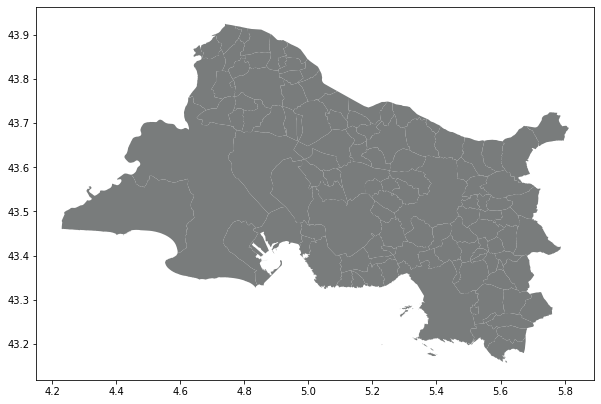

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
combdr.plot(ax=ax, color="#797c7c", linewidth=.7);

Et maintenant ? On va se pencher en premier lieu sur Marseille. Nous avons son strict contour communal, or le découpage par arrondissement est nécessaire pour la carte finale.

On va donc **purger Marseille de combdr**, en retenant simplement les communes dont le code INSEE est différent de "13055" :

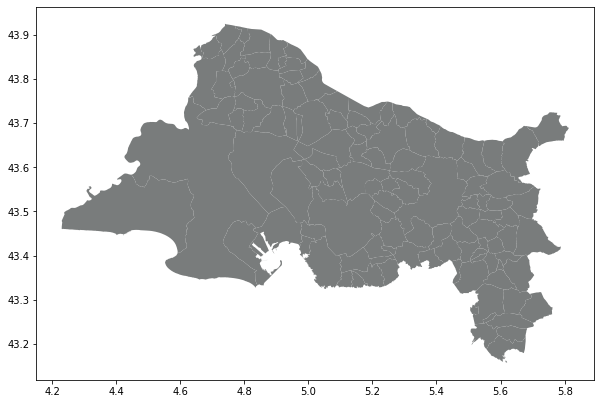

In [5]:
combdr=combdr[combdr["insee"]!="13055"].reset_index(drop=True)
fig, ax = plt.subplots(figsize=(10,10))
combdr.plot(ax=ax, color="#797c7c", linewidth=.7);

On va **créer une nouvelle GeoDataFrame** en lisant un fichier shapefile avec les contours d'arrondissements. Il se trouve dans le sous-dossier brut :

In [6]:
arrmars=gpd.read_file(r"brut\\arr_tout.shp")
# on va renommer les deux colonnes non géographiques pour qu'elles soient raccord à la GDF combdr
arrmars.rename(columns={"DEPCOM":"insee","NOM_COM":"nom"}, inplace=True)
arrmars.tail()

,insee,nom,geometry
11,13212,MARSEILLE 12E ARRONDISSEMENT,"POLYGON ((898102.000 6249721.000, 898116.000 6..."
12,13213,MARSEILLE 13E ARRONDISSEMENT,"POLYGON ((896734.000 6249990.000, 896727.000 6..."
13,13214,MARSEILLE 14E ARRONDISSEMENT,"POLYGON ((893832.000 6249187.000, 893806.000 6..."
14,13215,MARSEILLE 15E ARRONDISSEMENT,"POLYGON ((892807.000 6255246.000, 892826.000 6..."
15,13216,MARSEILLE 16E ARRONDISSEMENT,"POLYGON ((889097.000 6255276.000, 889165.000 6..."


16 entrées, aucun problème, mais par souci de cohérence on va reformarter les noms grâce à un dictionnaire :

In [7]:
corres_arr={"MARSEILLE 1ER ARRONDISSEMENT":"1er arrondissement de Marseille","MARSEILLE 2E ARRONDISSEMENT":"2e arrondissement de Marseille","MARSEILLE 3E ARRONDISSEMENT":"3e arrondissement de Marseille","MARSEILLE 4E ARRONDISSEMENT":"4e arrondissement de Marseille","MARSEILLE 5E ARRONDISSEMENT":"5e arrondissement de Marseille","MARSEILLE 6E ARRONDISSEMENT":"6e arrondissement de Marseille","MARSEILLE 7E ARRONDISSEMENT":"7e arrondissement de Marseille","MARSEILLE 8E ARRONDISSEMENT":"8e arrondissement de Marseille","MARSEILLE 9E ARRONDISSEMENT":"9e arrondissement de Marseille","MARSEILLE 10E ARRONDISSEMENT":"10e arrondissement de Marseille","MARSEILLE 11E ARRONDISSEMENT":"11e arrondissement de Marseille","MARSEILLE 12E ARRONDISSEMENT":"12e arrondissement de Marseille","MARSEILLE 13E ARRONDISSEMENT":"13e arrondissement de Marseille","MARSEILLE 14E ARRONDISSEMENT":"14e arrondissement de Marseille","MARSEILLE 15E ARRONDISSEMENT":"15e arrondissement de Marseille","MARSEILLE 16E ARRONDISSEMENT":"16e arrondissement de Marseille"}
# afin d'éviter toute ambiguïté, on peut convertir les colonnes en strictes chaînes de caractères
arrmars["insee"]=arrmars["insee"].astype(str)
arrmars["nom"]=arrmars["nom"].astype(str)
arrmars["nom"]=arrmars["nom"].map(corres_arr)
arrmars.tail()

,insee,nom,geometry
11,13212,12e arrondissement de Marseille,"POLYGON ((898102.000 6249721.000, 898116.000 6..."
12,13213,13e arrondissement de Marseille,"POLYGON ((896734.000 6249990.000, 896727.000 6..."
13,13214,14e arrondissement de Marseille,"POLYGON ((893832.000 6249187.000, 893806.000 6..."
14,13215,15e arrondissement de Marseille,"POLYGON ((892807.000 6255246.000, 892826.000 6..."
15,13216,16e arrondissement de Marseille,"POLYGON ((889097.000 6255276.000, 889165.000 6..."


Autre précaution : s'assurer que **la projection des deux GDF est la même**. L'acronyme anglais est CRS (pour *Coordinates Reference System*), et c'est aussi le nom d'un attribut de GeoDataFrame :

In [8]:
print(combdr.crs)
print(arrmars.crs)

epsg:4326
epsg:2154


Ce n'est pas la même, on va du coup convertir celle d'arrmars :

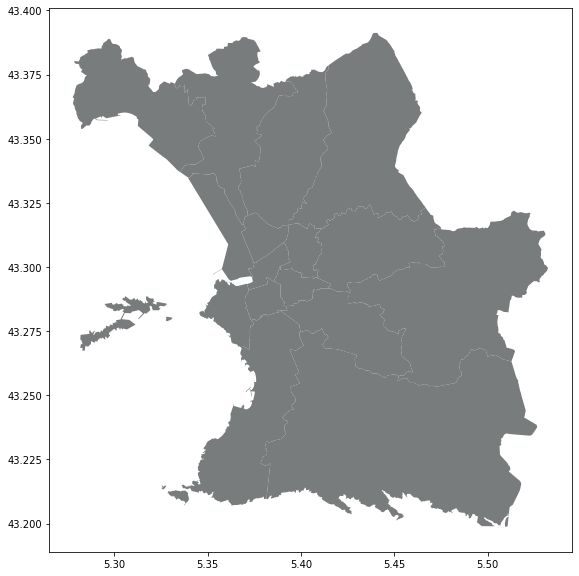

In [9]:
arrmars=arrmars.to_crs(4326)
fig, ax = plt.subplots(figsize=(10,10))
arrmars.plot(ax=ax, color="#797c7c", linewidth=.7);

On peut désormais ajouter les arrondissements aux Bouches-du-Rhône sans Marseille grâce à la fonction concat. Rappel : **les colonnes ont strictement les mêmes noms des deux côtés**, on n'aura donc aucun problème de cohérence. Cela dit, comme on passe par pandas, la variable est transformée en DataFrame. 

On peut la convertir facilement en GeoDataFrame. Il faudra juste préciser lors de cette création :
* les **coordonnées géographiques**, renseignés dans la colonne geometry
* la **projection**, toujours 4326 dans notre cas

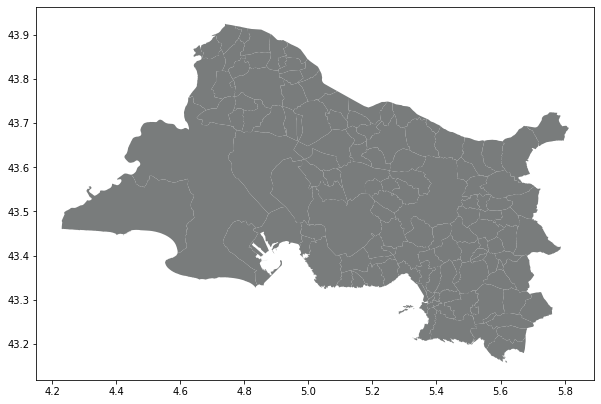

In [10]:
combdr=pd.concat([combdr,arrmars])
combdr=gpd.GeoDataFrame(combdr,geometry=combdr["geometry"],crs=4326)
fig, ax = plt.subplots(figsize=(10,10))
combdr.plot(ax=ax, color="#797c7c", linewidth=.7);

Rien ne dépasse, mais il manque un trou : **celui de l'Étang de Berre**. Ce dernier est inclus dans le ban communal de Berre-l'Étang (code INSEE 13014), que l'on va isoler dans une nouvelle GDF :

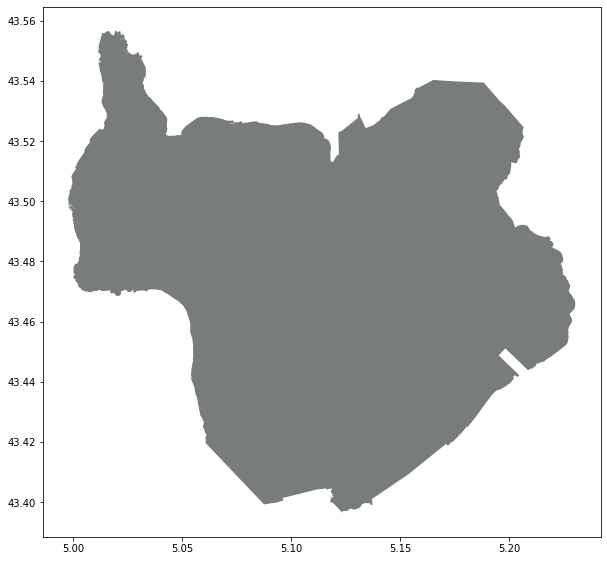

In [11]:
be=combdr.copy()
be=be[be["insee"]=="13014"]
fig, ax = plt.subplots(figsize=(10,10))
be.plot(ax=ax, color="#797c7c", linewidth=.7);

[On va utiliser les overlays](https://geopandas.org/en/stable/docs/user_guide/set_operations.html), une des fonctionnalités les plus puissantes de geopandas. Elle permet, lorsque deux entités géographiques se superposent, de définir ce que l'on retient (intersection, fusion et différences).

Mais il nous faut des entités à superposer, et on va importer [les contours de circonscription gracieusement fournis par l'INSEE](https://www.insee.fr/fr/statistiques/6441661?sommaire=6436478) :

In [12]:
circo=gpd.read_file("https://www.insee.fr/fr/statistiques/fichier/6441661/contours_circonscriptions_legislatives_03052022.zip")
circo.tail()

,id_circo,dep,libelle,geometry
553,0502,05,Hautes-Alpes - 2e circonscription,"MULTIPOLYGON (((6.23277 44.46288, 6.24026 44.4..."
554,0401,04,Alpes-de-Haute-Provence - 1re circonscription,"MULTIPOLYGON (((6.84988 43.91410, 6.83595 43.9..."
555,4204,42,Loire - 4e circonscription,"MULTIPOLYGON (((4.54255 45.24218, 4.53626 45.2..."
556,0703,07,Ardèche - 3e circonscription,"POLYGON ((4.05709 44.36415, 4.05709 44.36415, ..."
557,0501,05,Hautes-Alpes - 1re circonscription,"MULTIPOLYGON (((6.26146 44.54610, 6.26146 44.5..."


**La 8e circonscription des Bouches-du-Rhône inclut Berre-l'Étang sans sa vaste étendue d'eau**. On va appliquer un overlay entre les GeoDataFrame be et cette circonscription, **en retenant l'intersection** :

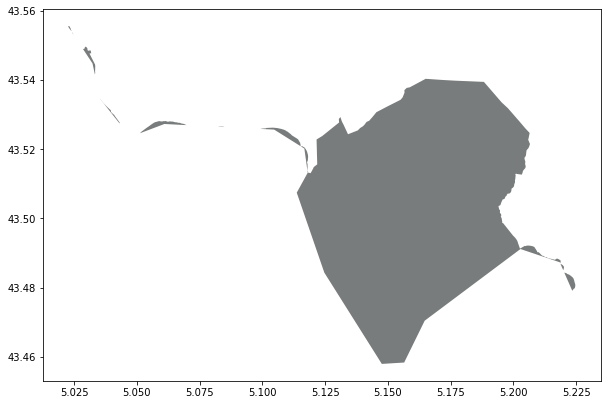

In [13]:
be=be.overlay(circo[circo["id_circo"]=="1308"], how='intersection')
be=be.dissolve(by='insee').reset_index()
fig, ax = plt.subplots(figsize=(10,10))
be.plot(ax=ax, color="#797c7c", linewidth=.7);

Vérifions que be reste conforme :

In [14]:
be

,insee,geometry,nom,id_circo,dep,libelle
0,13014,"MULTIPOLYGON (((5.05595 43.52723, 5.05685 43.5...",Berre-l'Étang,1308,13,Bouches-du-Rhône - 8e circonscription


Rien ne dépasse, encore une fois. On va refaire une bidouille similaire à celle des arrondissements marseillais, en :
* purgeant Berre-l'Étang (avec son fameux étang) de la GDF combdr
* concaténant combdr avec be (Berre-l'Étang stricte, sans la flotte)
* reformatant le résultat en GeoDataFrame

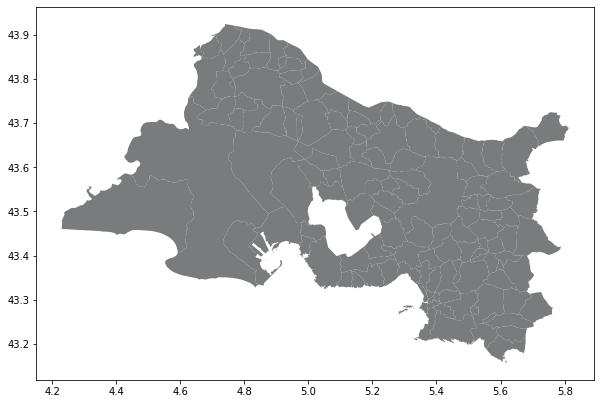

In [15]:
be=be[["insee","nom","geometry"]]
combdr=combdr[combdr["insee"]!="13014"]
combdr=pd.concat([combdr,be])
combdr=gpd.GeoDataFrame(combdr,geometry=combdr["geometry"],crs=4326)
fig, ax = plt.subplots(figsize=(10,10))
combdr.plot(ax=ax, color="#797c7c", linewidth=.7);

La GeoDataFrame combdr évolue, bon an mal an. On va à présent se préoccuper **des communes et arrondissements marseillais éclatés entre plusieurs circonscription**. Les nominés sont :
* les communes d'Aix-en-Provence et d'Istres (codes INSEE 13001 et 13047)
* les 5e, 6e, 10e, 12e et 14e arrondissements de Marseille

Cela va impliquer la création d'une nouvelle GDF, centrée sur ces villes particulières. Il suffit d'utiliser un filtre sur la colonne de codes INSEE sur une copie de combdr pour y arriverr :

In [16]:
l_insee=["13001","13047","13205","13206","13210","13212","13214"]
vp=combdr.copy()
vp=vp[vp["insee"].isin(l_insee)]
vp

,insee,nom,geometry
1,13001,Aix-en-Provence,"POLYGON ((5.26947 43.49617, 5.26965 43.49648, ..."
29,13047,Istres,"POLYGON ((4.87977 43.54145, 4.88201 43.54323, ..."
4,13205,5e arrondissement de Marseille,"POLYGON ((5.39896 43.28692, 5.39879 43.28692, ..."
5,13206,6e arrondissement de Marseille,"POLYGON ((5.38911 43.28997, 5.38912 43.28931, ..."
9,13210,10e arrondissement de Marseille,"POLYGON ((5.44225 43.28141, 5.44224 43.28128, ..."
11,13212,12e arrondissement de Marseille,"POLYGON ((5.44113 43.31908, 5.44131 43.31912, ..."
13,13214,14e arrondissement de Marseille,"POLYGON ((5.38835 43.31546, 5.38801 43.31501, ..."


On va faire de même côté circonscription en ne retenant que celles scindant des villes ou des arrondissements. Principe strictement identique :

In [17]:
sp_circo=circo.copy()
sp_circo=sp_circo[sp_circo["id_circo"].astype(str).str.rjust(4,"0").isin(["1301","1303","1304","1305","1306","1307","1311","1313","1314","1316"])]

Et on superpose les deux afin d'avoir une vague idée du redécoupage à venir :

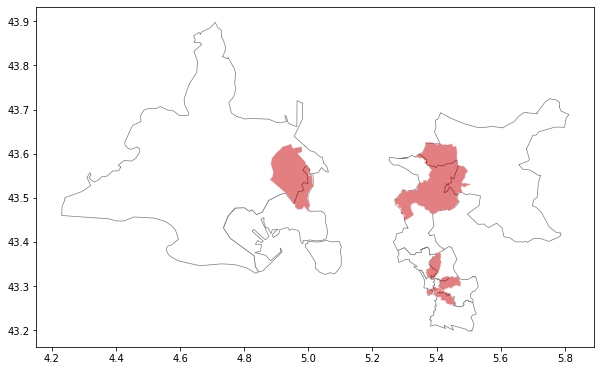

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
sp_circo.plot(ax=ax, color="#fff", edgecolor="#797c7c", linewidth=.7)
vp.plot(ax=ax, color="#c90004", edgecolor="#fff", linewidth=.7, alpha=.5);

On va **rentabiliser ce qui a été fait avant sur l'Étang de Berre**, en liant chaque ville/arrondissement aux circonscription les scindant dans un dictionnaire et en bouclant dessus pour isoler la géographie d'intersection.

Chaque GeoDataFrame isolée sera ajoutée dans un GDF remplie au fur et à mesure et à l'arrivée... Nous aurons les communes et arrondissements bien dissocés :

In [19]:
def geo_tranchage(GDF_modele:gpd.geodataframe.GeoDataFrame,col_modele:str,GDF_cible:gpd.geodataframe.GeoDataFrame,col_cible:str,dico_rassemblement:dict,fcrs:int):
    """
        Cette fonction "tranche" des polygones géographiques suivant les contours d'autre contours.
        Par exemple : découper la ville de Mulhouse en deux morceaux, un pour chaque circo législative qui la chevauche.
    """
    # d'abord, les colonnes de la GDF finale
    l_col=list(set(list(GDF_modele.columns)+list(GDF_cible.columns)))
    DF_finale=pd.DataFrame(columns=l_col)
    for c in dico_rassemblement.keys():
        for m in dico_rassemblement[c]:
            GDF_tamp=GDF_cible.copy()
            GDF_tamp=GDF_cible[GDF_cible[col_cible]==c]
            GDF_tamp=GDF_tamp.overlay(GDF_modele[GDF_modele[col_modele]==m], how='intersection',keep_geom_type=False)
            GDF_tamp=GDF_tamp.dissolve(by=col_cible).reset_index()
            DF_finale=pd.concat([DF_finale,GDF_tamp])
    DF_finale.reset_index(drop=True,inplace=True)
    GDF_finale=gpd.GeoDataFrame(DF_finale,geometry=DF_finale["geometry"],crs=fcrs)
    return GDF_finale

Plus qu'à tester cette fonction en créant une nouvelle variable :

In [20]:
circo_sp=geo_tranchage(sp_circo,"id_circo",vp,"insee",{"13001":["1311","1314"],"13047":["1313","1316"],"13205":["1304","1305"],"13206":["1304","1305"],"13210":["1301","1306"],"13212":["1301","1303"],"13214":["1303","1307"]},4326)

Et à visualiser :

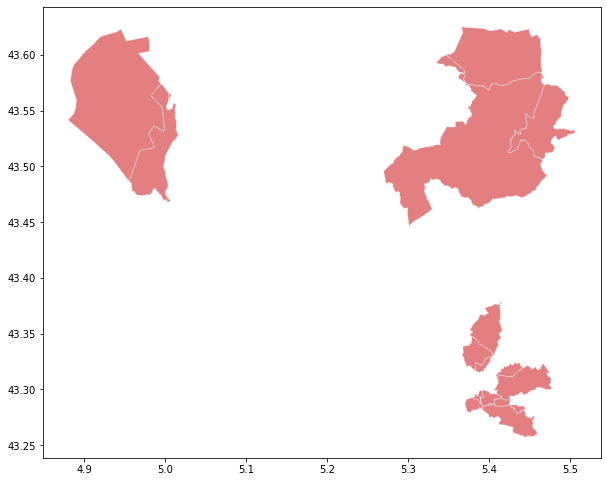

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
circo_sp.plot(ax=ax, color="#c90004", edgecolor="#fff", linewidth=.7, alpha=.5);

Tout a fonctionné comme attendu. Observons les dernières lignes de circo_sp :

In [22]:
circo_sp.tail()

,id_circo,dep,nom,libelle,insee,geometry
9,1306,13,10e arrondissement de Marseille,Bouches-du-Rhône - 6e circonscription,13210,"POLYGON ((5.44276 43.28090, 5.44276 43.28089, ..."
10,1301,13,12e arrondissement de Marseille,Bouches-du-Rhône - 1re circonscription,13212,"POLYGON ((5.44131 43.31912, 5.44146 43.31917, ..."
11,1303,13,12e arrondissement de Marseille,Bouches-du-Rhône - 3e circonscription,13212,"MULTIPOLYGON (((5.40826 43.31163, 5.40809 43.3..."
12,1303,13,14e arrondissement de Marseille,Bouches-du-Rhône - 3e circonscription,13214,"MULTIPOLYGON (((5.38797 43.31497, 5.38797 43.3..."
13,1307,13,14e arrondissement de Marseille,Bouches-du-Rhône - 7e circonscription,13214,"MULTIPOLYGON (((5.37924 43.31881, 5.37918 43.3..."


Nous allons procéder à quelques transformations qui vons consister à :
* changer la colonne de nom en suivant le modèle "nom de ville-id de la circo"
* nettoyer la colonne libelle
* modifier des noms de colonnes et ne retenir que celles communes à combdr

In [23]:
corr_circ={'1301':"1ère circonscription des Bouches-du-Rhône",'1302':"2e circonscription des Bouches-du-Rhône",'1303':"3e circonscription des Bouches-du-Rhône",'1304':"4e circonscription des Bouches-du-Rhône",'1305':"5e circonscription des Bouches-du-Rhône",'1306':"6e circonscription des Bouches-du-Rhône",'1307':"7e circonscription des Bouches-du-Rhône",'1308':"8e circonscription des Bouches-du-Rhône",'1309':"9e circonscription des Bouches-du-Rhône",'1310':"10e circonscription des Bouches-du-Rhône",'1311':"11e circonscription des Bouches-du-Rhône",'1312':"12e circonscription des Bouches-du-Rhône",'1313':"13e circonscription des Bouches-du-Rhône",'1314':"14e circonscription des Bouches-du-Rhône",'1315':"15e circonscription des Bouches-du-Rhône",'1316':"16e circonscription des Bouches-du-Rhône"}
circo_sp["nom"]=circo_sp["nom"]+"-"+circo_sp["id_circo"].str.slice(start=2).str.replace("0","")
circo_sp["libelle"]=circo_sp["id_circo"].map(corr_circ)
circo_sp.rename(columns={"id_circo":"id"},inplace=True)
circo_sp=circo_sp[["id","insee","nom","libelle","geometry"]]
circo_sp.tail()

,id,insee,nom,libelle,geometry
9,1306,13210,10e arrondissement de Marseille-6,6e circonscription des Bouches-du-Rhône,"POLYGON ((5.44276 43.28090, 5.44276 43.28089, ..."
10,1301,13212,12e arrondissement de Marseille-1,1ère circonscription des Bouches-du-Rhône,"POLYGON ((5.44131 43.31912, 5.44146 43.31917, ..."
11,1303,13212,12e arrondissement de Marseille-3,3e circonscription des Bouches-du-Rhône,"MULTIPOLYGON (((5.40826 43.31163, 5.40809 43.3..."
12,1303,13214,14e arrondissement de Marseille-3,3e circonscription des Bouches-du-Rhône,"MULTIPOLYGON (((5.38797 43.31497, 5.38797 43.3..."
13,1307,13214,14e arrondissement de Marseille-7,7e circonscription des Bouches-du-Rhône,"MULTIPOLYGON (((5.37924 43.31881, 5.37918 43.3..."


On ne va pas s'arrêter là, et inclure également les arrondissements de Marseille entiers :

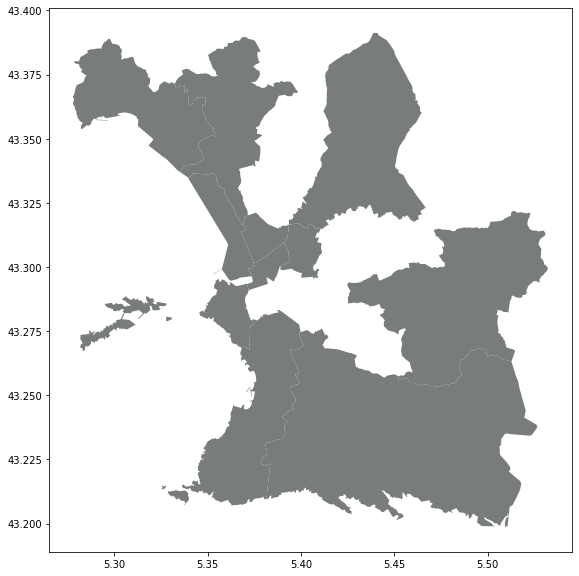

In [24]:
insee_retenu=["13201","13202","13203","13204","13207","13208","13209","13211","13213","13215","13216"]
vr=combdr.copy()
vr=vr[vr["insee"].isin(insee_retenu)]
fig, ax = plt.subplots(figsize=(10,10))
vr.plot(ax=ax, color="#797c7c", linewidth=.7);

Et refaire les mêmes transformations qu'avant, pour concaténer ces arrondissements à la GDF circo_sp :

In [25]:
corr_retenu={"13201":"1304","13202":"1304","13203":"1304","13204":"1305","13207":"1302","13208":"1302","13209":"1306","13211":"1301","13213":"1303","13215":"1307","13216":"1307"}
vr["id"]=vr["insee"].map(corr_retenu)
vr["libelle"]=vr["id"].map(corr_circ)
vr=vr[["id","insee","nom","libelle","geometry"]]
circo_sp=pd.concat([circo_sp,vr])
circo_sp.reset_index(drop=True, inplace=True)
circo_sp=gpd.GeoDataFrame(circo_sp,geometry=circo_sp["geometry"],crs=4326)
circo_sp.tail()

,id,insee,nom,libelle,geometry
20,1306,13209,9e arrondissement de Marseille,6e circonscription des Bouches-du-Rhône,"POLYGON ((5.39717 43.26217, 5.39692 43.26259, ..."
21,1301,13211,11e arrondissement de Marseille,1ère circonscription des Bouches-du-Rhône,"POLYGON ((5.42625 43.28587, 5.42607 43.28586, ..."
22,1303,13213,13e arrondissement de Marseille,3e circonscription des Bouches-du-Rhône,"POLYGON ((5.42439 43.32188, 5.42430 43.32175, ..."
23,1307,13215,15e arrondissement de Marseille,7e circonscription des Bouches-du-Rhône,"POLYGON ((5.37798 43.37022, 5.37820 43.37004, ..."
24,1307,13216,16e arrondissement de Marseille,7e circonscription des Bouches-du-Rhône,"POLYGON ((5.33226 43.37148, 5.33303 43.36992, ..."


On peut à présent purger de bdr toutes les parties de communes, parties d'arrondissements et arrrondissements complets :

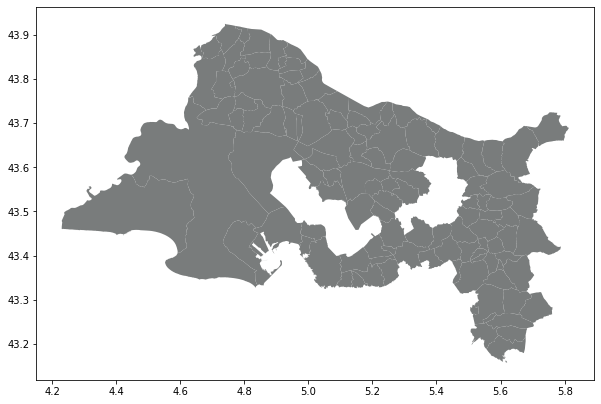

In [26]:
combdr=combdr[~combdr["insee"].isin(l_insee)]
combdr=combdr[~combdr["insee"].isin(insee_retenu)]
fig, ax = plt.subplots(figsize=(10,10))
combdr.plot(ax=ax, color="#797c7c", linewidth=.7);

## Ajout des circonscriptions

Tout ceci pour en arriver à l'augmentation de ces données communales avec les identifiants et libellés de circonscription correspondants. On va utiliser pandas et charger dans une nouvelle DataFrame [la table de correspondance](https://www.data.gouv.fr/fr/datasets/circonscriptions-legislatives-table-de-correspondance-des-communes-et-des-cantons-pour-les-elections-legislatives-de-2012-et-sa-mise-a-jour-pour-les-elections-legislatives-2017/) fournie par l'Intérieur :

In [27]:
tc_circo=pd.read_excel(r"https://www.data.gouv.fr/fr/datasets/r/0a12df6c-de18-44ec-aaf1-0e7d5ab6240f",header=1)
tc_circo.tail()

,Code dépt-canton,Code département,Nom département,Code canton,Nom canton,Code commune,Nom commune,Circ. législative 1986,Circ. législative 2012
37870,ZD45,ZD,LA REUNION,45,SAINT-BENOIT 2,410,Saint-Benoît,5,5
37871,ZD46,ZD,LA REUNION,46,SAINT-PAUL 4,415,Saint-Paul,2,7
37872,ZD47,ZD,LA REUNION,47,SAINT-PAUL 5,415,Saint-Paul,2,7
37873,ZD48,ZD,LA REUNION,48,ST-ANDRE III,409,Saint-André,5,5
37874,ZD49,ZD,LA REUNION,49,LE TAMPON IV,422,Le Tampon,3,3


On va renommer les colonnes et ne garder que celles qui nous intéressent :

In [28]:
ncol={"Code département":"dep","Nom commune":"nom","Code commune":"code_co","Circ. législative 2012":"cir_2012"}
tc_circo.rename(columns=ncol, inplace=True)
tc_circo=tc_circo[list(ncol.values())]
tc_circo.tail()

,dep,nom,code_co,cir_2012
37870,ZD,Saint-Benoît,410,5
37871,ZD,Saint-Paul,415,7
37872,ZD,Saint-Paul,415,7
37873,ZD,Saint-André,409,5
37874,ZD,Le Tampon,422,3


Ensuite, on reformate les colonnes de codes départemental, communal, et de circonscription afin d'inclure d'éventuels 0. Cela se fait [grâce à la fonction rjust](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.rjust.html) :

In [29]:
tc_circo["code_co"]=tc_circo["code_co"].astype(str).str.rjust(3,"0")
tc_circo["cir_2012"]=tc_circo["cir_2012"].astype(str).str.rjust(2,"0")
tc_circo["dep"]=tc_circo["dep"].astype(str).str.rjust(2,"0")
tc_circo.head()

,dep,nom,code_co,cir_2012
0,01,L'Abergement-de-Varey,002,05
1,01,Ambérieu-en-Bugey,004,05
2,01,Ambronay,007,05
3,01,Bettant,041,05
4,01,Château-Gaillard,089,05


On ne va ensuite retenir que les communes des Bouches-du-Rhône et transformer les colonnes de codes INSEE et circonsccription sur le même modèle que précédemment, en additionnant le code départemental avec le code communal ou de circonscription :

In [30]:
tc_bdr=tc_circo.copy()
tc_bdr=tc_bdr[tc_bdr["dep"].isin(["13"])].reset_index(drop=True)
tc_bdr["id"]=tc_bdr["dep"]+tc_bdr["cir_2012"]
tc_bdr["insee"]=tc_bdr["dep"]+tc_bdr["code_co"]
tc_bdr=tc_bdr[["insee","nom","id"]]
tc_bdr.tail()

,insee,nom,id
252,13055AR08,Marseille 8eme arrondissement,1302
253,13055SR04,Marseille Secteur 4,1302
254,13055,Marseille,1305
255,13055AR06,Marseille 6eme arrondissement,1305
256,13055SR04,Marseille Secteur 4,1305


Remarquez les codes de Marseille, qui ont justifié la purge précédente. On va augmenter les données avec une colonne de libellé basé sur un dictionnaire précédent :

In [31]:
tc_bdr["libelle"]=tc_bdr["id"].map(corr_circ)
tc_bdr=tc_bdr[["insee","id","libelle"]]
tc_bdr.tail()

,insee,id,libelle
252,13055AR08,1302,2e circonscription des Bouches-du-Rhône
253,13055SR04,1302,2e circonscription des Bouches-du-Rhône
254,13055,1305,5e circonscription des Bouches-du-Rhône
255,13055AR06,1305,5e circonscription des Bouches-du-Rhône
256,13055SR04,1305,5e circonscription des Bouches-du-Rhône


Et à présent, on va faire une fusion sur les communes des Bouches-du-Rhône, de façon à ce que les codes INSEE présents dans tc_bdr mais absent de combdr ne soient pas pris en compte :

In [32]:
com_bdr=combdr.copy()
com_bdr=com_bdr.merge(tc_bdr,on="insee")
com_bdr=gpd.GeoDataFrame(com_bdr,geometry=com_bdr["geometry"],crs=4326)
com_bdr.tail()

,insee,nom,geometry,id,libelle
114,13007,Auriol,"POLYGON ((5.60689 43.37052, 5.60692 43.37061, ...",1310,10e circonscription des Bouches-du-Rhône
115,13016,La Bouilladisse,"POLYGON ((5.58188 43.40492, 5.58223 43.40497, ...",1310,10e circonscription des Bouches-du-Rhône
116,13086,Roquevaire,"POLYGON ((5.54614 43.34455, 5.54841 43.34434, ...",1310,10e circonscription des Bouches-du-Rhône
117,13110,Trets,"POLYGON ((5.63905 43.40411, 5.64223 43.40822, ...",1314,14e circonscription des Bouches-du-Rhône
118,13014,Berre-l'Étang,"MULTIPOLYGON (((5.05595 43.52723, 5.05685 43.5...",1308,8e circonscription des Bouches-du-Rhône


Et on visualise pour s'assurer que tout roule :

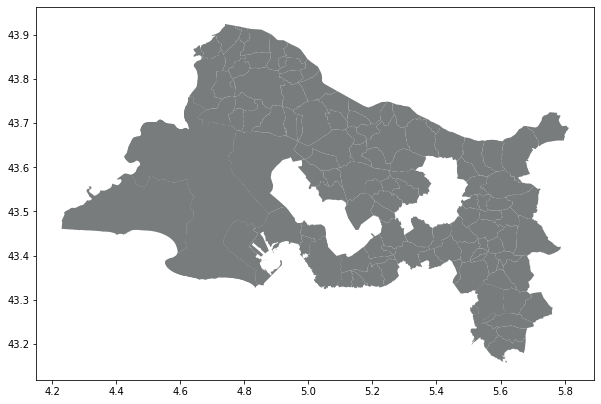

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
com_bdr.plot(ax=ax, color="#797c7c", linewidth=.7);

Dernière coquetterie : virer les éventuels doublons, par exemple pour Arles, Martigues ou Aubagne : 

In [34]:
com_bdr[com_bdr["nom"].isin(["Arles","Aubagne","Martigues"])]

,insee,nom,geometry,id,libelle
10,13004,Arles,"POLYGON ((4.42608 43.62325, 4.42611 43.62390, ...",1316,16e circonscription des Bouches-du-Rhône
11,13004,Arles,"POLYGON ((4.42608 43.62325, 4.42611 43.62390, ...",1316,16e circonscription des Bouches-du-Rhône
58,13056,Martigues,"MULTIPOLYGON (((4.98509 43.39413, 4.98515 43.3...",1313,13e circonscription des Bouches-du-Rhône
59,13056,Martigues,"MULTIPOLYGON (((4.98509 43.39413, 4.98515 43.3...",1313,13e circonscription des Bouches-du-Rhône
80,13005,Aubagne,"POLYGON ((5.51322 43.26338, 5.51485 43.26747, ...",1309,9e circonscription des Bouches-du-Rhône
81,13005,Aubagne,"POLYGON ((5.51322 43.26338, 5.51485 43.26747, ...",1309,9e circonscription des Bouches-du-Rhône


La [fonction drop_duplicates](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html) est dédiée à cela. On l'applique, et on n'en parle plus :

In [35]:
com_bdr.drop_duplicates(inplace=True)
com_bdr[com_bdr["nom"].isin(["Arles","Aubagne","Martigues"])]

,insee,nom,geometry,id,libelle
10,13004,Arles,"POLYGON ((4.42608 43.62325, 4.42611 43.62390, ...",1316,16e circonscription des Bouches-du-Rhône
58,13056,Martigues,"MULTIPOLYGON (((4.98509 43.39413, 4.98515 43.3...",1313,13e circonscription des Bouches-du-Rhône
80,13005,Aubagne,"POLYGON ((5.51322 43.26338, 5.51485 43.26747, ...",1309,9e circonscription des Bouches-du-Rhône


Plus qu'à enfin ajouter la GDF circo_sp, et ses colonnnes strictement identiques :

In [36]:
com_bdr=pd.concat([com_bdr,circo_sp])
com_bdr=gpd.GeoDataFrame(com_bdr,geometry=com_bdr["geometry"],crs=4326)

Dernière visualisation :

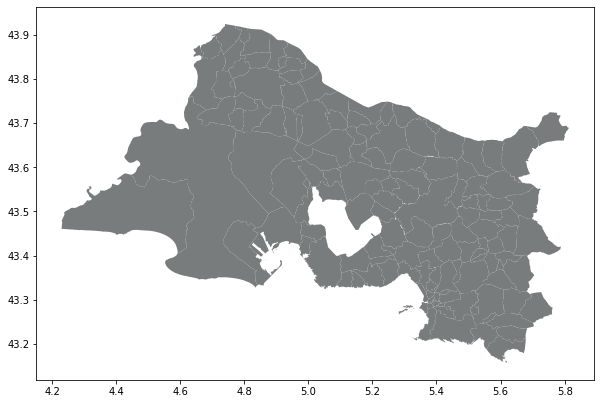

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
com_bdr.plot(ax=ax, color="#797c7c", linewidth=.7);

On va maintenant créer une nouvelle DataFrame dédiées aux circos législatives. Cela va se créer très facilement grâce à l'id présent dans com_bdr :

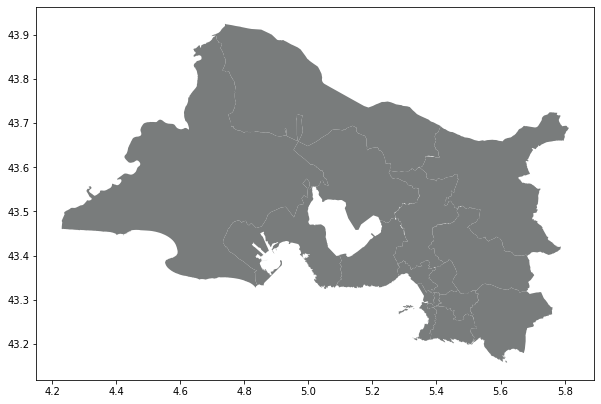

In [38]:
circo_leg=com_bdr.dissolve(by='id').reset_index()
fig, ax=plt.subplots(figsize=(10,10))
circo_leg.plot(ax=ax, color="#797c7c", linewidth=.7);

Une fois ceci fait, on peut enfin enregistrer le fichier communal après avoir simplifié sa géométrie :

In [39]:
com_bdr["geometry"]=com_bdr["geometry"].simplify(.00059)
com_bdr.to_file("data/circommunes.json", driver="GeoJSON")

C:\Users\Rapha\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Et faire de même avec les circonscriptions législatives :

In [40]:
circo_leg["geometry"]=circo_leg["geometry"].simplify(.00005)
circo_leg.to_file(r"data/circbdr.json", driver="GeoJSON")

C:\Users\Rapha\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Jointures des données tabulaires

Nous allons enfin passer aux données saisies dans Google Spreadsheet. Avant toute chose, on va relire dans une GeoDataFrame le fichier par circonscription créé précédemment. Cela évitera de refaire toutes les opérations précédentes afin de ne se consacrer qu'à la màj :

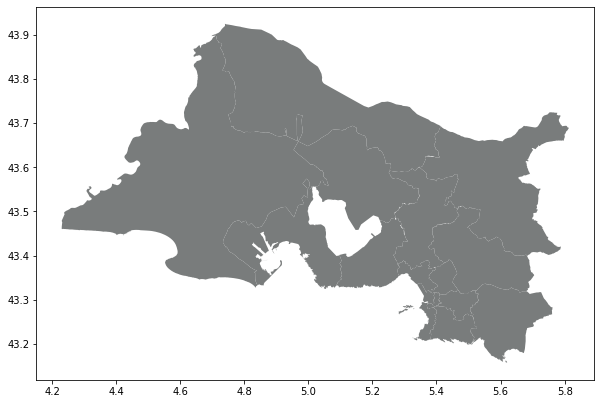

In [2]:
circbdr=gpd.read_file(r"data/circbdr.json")
fig, ax=plt.subplots(figsize=(10,10))
circbdr.plot(ax=ax, color="#797c7c", linewidth=.7);

On va se concentrer sur un premier csv de contextualisation, téléchargé depuis Google Spredsheet.

Il suit le schéma suivant :
* **id** : chaînes de caractères de quatre chiffres, deux pour le département, deux pour le numéro de circo
* **libelle** : nom de la circo, le plus scolaire qui soit ("1ère circonscription du Rhône")
* **depute** : le nom du sortant ou de la sortante
* **et_depute** : l'étiquette politique de la personne en question
* **contexte** : un paragraphe résumant l'enjeu de la circo

Chargeons tout ça dans une nouvelle DataFrame :

In [3]:
desc=pd.read_csv(r"brut/circo_bdr.csv")
desc=desc[["id","depute","et_depute","contexte"]]
desc.tail()

,id,depute,et_depute,contexte
11,1312,Éric Diard,LR,C'est l'un de deux sortants LR encore en lice....
12,1313,Pierre Dharréville,PC,Le dernier député communiste du département se...
13,1314,Anne-Laurence Petel,Renaissance,Terre de domination macroniste dans les électi...
14,1315,Bernard Reynès,LR,C'est l'un de deux sortants LR encore en lice ...
15,1316,Monica Michel,Renaissance,La représentante de la majorité présidentielle...


Une ligne par circonscription, le même nombre que la GDF circbdr. On va pouvoir les fusionner à partir de la colonne commune "id", et obtenir une GDF augmentée des données précédentes :

In [4]:
desc["id"]=desc["id"].astype(str)
circbdr["id"]=circbdr["id"].astype(str)
circbdr=circbdr.merge(desc,on="id")
circbdr=gpd.GeoDataFrame(circbdr,geometry=circbdr["geometry"],crs=4326)
circbdr.tail()

,id,insee,nom,libelle,geometry,depute,et_depute,contexte
11,1312,13117,Vitrolles,12e circonscription des Bouches-du-Rhône,"MULTIPOLYGON (((5.23544 43.32990, 5.23672 43.3...",Éric Diard,LR,C'est l'un de deux sortants LR encore en lice....
12,1313,13078,Port-Saint-Louis-du-Rhône,13e circonscription des Bouches-du-Rhône,"MULTIPOLYGON (((5.08019 43.32476, 5.08022 43.3...",Pierre Dharréville,PC,Le dernier député communiste du département se...
13,1314,13080,Le Puy-Sainte-Réparade,14e circonscription des Bouches-du-Rhône,"POLYGON ((5.50192 43.46707, 5.50255 43.46754, ...",Anne-Laurence Petel,Renaissance,Terre de domination macroniste dans les électi...
14,1315,13064,Mollégès,15e circonscription des Bouches-du-Rhône,"POLYGON ((4.96469 43.71937, 4.96417 43.71113, ...",Bernard Reynès,LR,C'est l'un de deux sortants LR encore en lice ...
15,1316,13004,Arles,16e circonscription des Bouches-du-Rhône,"POLYGON ((4.23019 43.46149, 4.23037 43.46268, ...",Monica Michel,Renaissance,La représentante de la majorité présidentielle...


Passons maintenant à la feuille de candidats. Le schéma retenu est le suivant :

* **nom** : comme son nom l'indique
* **circo** : le fameux code à quatre chiffres qui va permettre de rassembler et jointurer avec l'autre feuille
* **nuance** : l'étiquette ou bannière sous laquelle se présente le candidat ("NUPES", par exemple)
* **etiquette** : l'étiquette personnelle du candidat, par exemple "LFI", "EELV", "PS" ou "PCF" pour un candidat de NUPES
* **sortant** : que deux possibilités, "oui" ou "non"
* **d_naissance** : attention à bien respecter le format jj/mm/aaaa, dont je me servirais pour calculer l'âge des intéressés dans mes scripts de préparation de données
* **age** : nombre entier, calculé à partir d'une fonction dédiée dans GSpreadsheet
mandats : une phrase résumant les mandats ou l'absence de mandat en cours
* **profession** : RAS
* **photo** : un lien pointant vers une photo hébergée dans un dossier Google Drive **consultable par tous**

Cette description faite, on va charger la DF et ne retenir que certaines colonnes :

In [5]:
candidats=pd.read_csv(r"brut\\candidats_bdr.csv")
candidats=candidats[["nom","circonscription","nuance","etiquette","age","mandats","profession","photo"]]
candidats.tail()

,nom,circonscription,nuance,etiquette,age,mandats,profession,photo
196,Nicolas Lapeyre,1315,SE,SE,34,Pas d'autre mandat connu,Profession libérale,https://drive.google.com/file/d/1T-TAPb05EeN9P...
197,Mounia Banderier-Zahir,1315,SE,SE,40,Pas d'autre mandat connu,Employé civil et agent de service de la foncti...,https://drive.google.com/file/d/1T-TAPb05EeN9P...
198,Jean-Baptiste Meloni,1316,SE,SE,34,Pas d'autre mandat connu,Artisan,https://drive.google.com/file/d/1T-TAPb05EeN9P...
199,Grégory Sanchez,1316,SE,SE,43,Pas d'autre mandat connu,Employé administratif d'entreprise,https://drive.google.com/file/d/1T-TAPb05EeN9P...
200,Céline Caravellazi,1301,SE,Droite souverainiste,47,Pas d'autre mandat connu,Artisan,https://drive.google.com/file/d/1T-TAPb05EeN9P...


On va d'abord nettoyer la colonne "age", qui peut selon les cas être parfois interprété comme un nombre à décimales :

In [6]:
candidats["age"]=candidats["age"].astype(str).str.split(".").str[0]
candidats.tail()

,nom,circonscription,nuance,etiquette,age,mandats,profession,photo
196,Nicolas Lapeyre,1315,SE,SE,34,Pas d'autre mandat connu,Profession libérale,https://drive.google.com/file/d/1T-TAPb05EeN9P...
197,Mounia Banderier-Zahir,1315,SE,SE,40,Pas d'autre mandat connu,Employé civil et agent de service de la foncti...,https://drive.google.com/file/d/1T-TAPb05EeN9P...
198,Jean-Baptiste Meloni,1316,SE,SE,34,Pas d'autre mandat connu,Artisan,https://drive.google.com/file/d/1T-TAPb05EeN9P...
199,Grégory Sanchez,1316,SE,SE,43,Pas d'autre mandat connu,Employé administratif d'entreprise,https://drive.google.com/file/d/1T-TAPb05EeN9P...
200,Céline Caravellazi,1301,SE,Droite souverainiste,47,Pas d'autre mandat connu,Artisan,https://drive.google.com/file/d/1T-TAPb05EeN9P...


Ensuite on va isoler l'id de chaque photographie hébergée sur Google Drive grâce à une expression régulière :

In [7]:
candidats["id_photo"]=candidats["photo"].str.extract(r'https:\/\/drive\.google\.com\/file\/d\/(1.*)\/')
candidats.tail()

,nom,circonscription,nuance,etiquette,age,mandats,profession,photo,id_photo
196,Nicolas Lapeyre,1315,SE,SE,34,Pas d'autre mandat connu,Profession libérale,https://drive.google.com/file/d/1T-TAPb05EeN9P...,1T-TAPb05EeN9P39s8O3ZFwKDBSkU0hx5
197,Mounia Banderier-Zahir,1315,SE,SE,40,Pas d'autre mandat connu,Employé civil et agent de service de la foncti...,https://drive.google.com/file/d/1T-TAPb05EeN9P...,1T-TAPb05EeN9P39s8O3ZFwKDBSkU0hx5
198,Jean-Baptiste Meloni,1316,SE,SE,34,Pas d'autre mandat connu,Artisan,https://drive.google.com/file/d/1T-TAPb05EeN9P...,1T-TAPb05EeN9P39s8O3ZFwKDBSkU0hx5
199,Grégory Sanchez,1316,SE,SE,43,Pas d'autre mandat connu,Employé administratif d'entreprise,https://drive.google.com/file/d/1T-TAPb05EeN9P...,1T-TAPb05EeN9P39s8O3ZFwKDBSkU0hx5
200,Céline Caravellazi,1301,SE,Droite souverainiste,47,Pas d'autre mandat connu,Artisan,https://drive.google.com/file/d/1T-TAPb05EeN9P...,1T-TAPb05EeN9P39s8O3ZFwKDBSkU0hx5


Et changer le contenu de la colonne "photo" en utilisant cette id pour pouvoir l'afficher comme une image à part entière :

In [8]:
candidats["photo"]="https://drive.google.com/uc?export=view&id="+candidats["id_photo"]
candidats=candidats[["nom","circonscription","nuance","etiquette","age","mandats","profession","photo"]]
candidats.tail()

,nom,circonscription,nuance,etiquette,age,mandats,profession,photo
196,Nicolas Lapeyre,1315,SE,SE,34,Pas d'autre mandat connu,Profession libérale,https://drive.google.com/uc?export=view&id=1T-...
197,Mounia Banderier-Zahir,1315,SE,SE,40,Pas d'autre mandat connu,Employé civil et agent de service de la foncti...,https://drive.google.com/uc?export=view&id=1T-...
198,Jean-Baptiste Meloni,1316,SE,SE,34,Pas d'autre mandat connu,Artisan,https://drive.google.com/uc?export=view&id=1T-...
199,Grégory Sanchez,1316,SE,SE,43,Pas d'autre mandat connu,Employé administratif d'entreprise,https://drive.google.com/uc?export=view&id=1T-...
200,Céline Caravellazi,1301,SE,Droite souverainiste,47,Pas d'autre mandat connu,Artisan,https://drive.google.com/uc?export=view&id=1T-...


Contrairement à la base précédente, nous avons 201 lignes contre 16 attendues. L'idéal serait d'avoir **une ligne par circo**, par exemple en rassemblant les candidats de chaque circonscription dans un dictionnaire.

Devinez quoi ? Je l'avais fait pour les départementales de 2021, et la fonction en question se recycle très bien. La preuve :

In [9]:
def dic_candidats(x):
    tab=[]
    for a,b,c,d,e,f,g in zip(x["nom"],x["nuance"], x["etiquette"], x["age"], x["mandats"],x["profession"], x["photo"]):
        dic={"nom":a,"nuance":b, "etiquette":c, "age":d, "mandats":e, "profession":f, "photo":g}
        tab.append(dic)
    return tab

On va nettoyer autant que possible les éventuelles cellules vides de la DF candidats en transformant chaque colonne en cchaînes de caractères :

In [10]:
for c in candidats.columns:
    candidats[c]=candidats[c].astype(str)
    candidats[c].fillna("Et galère", inplace=True)

candidats.iloc[-1]

nom                                               Céline Caravellazi
circonscription                                                 1301
nuance                                                            SE
etiquette                                       Droite souverainiste
age                                                               47
mandats                                     Pas d'autre mandat connu
profession                                                   Artisan
photo              https://drive.google.com/uc?export=view&id=1T-...
Name: 200, dtype: object

On peut enfin utiliser la fonction précédente pour obtenir une nouvelle DataFrame qui aura à l'arrivée deux colonnes :
* un id de circonscription, qui servira pour une fusion
* lcandidats, qui regroupera dans une liste de dictionnaires les différents candidats de chaque circo

In [11]:
candidats.rename(columns={"circonscription":"id"}, inplace=True)
# d'abord, DF vide
lcandidats=pd.DataFrame(columns=["id","lcandidats"])
# ensuite, DF tampon
tampon=candidats.groupby(candidats["id"]).apply(dic_candidats)
# qu'on réimplante proprement dans la DF vide
lcandidats["id"]=tampon.index
lcandidats["lcandidats"]=tampon.values
lcandidats.head()

,id,lcandidats
0,1301,"[{'nom': 'Thibaud Rosique', 'nuance': 'NUPES',..."
1,1302,"[{'nom': 'Alexandre Rupnik', 'nuance': 'NUPES'..."
2,1303,"[{'nom': 'Mohamed Bensaada', 'nuance': 'NUPES'..."
3,1304,"[{'nom': 'Manuel Bompard', 'nuance': 'NUPES', ..."
4,1305,"[{'nom': 'Hendrik Davi', 'nuance': 'NUPES', 'e..."


On peut ensuite fusionner/retransformer en GDF comme précédemment :

In [12]:
circbdr["id"]=circbdr["id"].astype(str)
bdr=circbdr.merge(lcandidats,on="id")
bdr=gpd.GeoDataFrame(bdr,geometry=bdr["geometry"],crs=4326)
# on doit convertir en str lcandidats pour éviter un plantage, ce qui ne la change pas en str pour autant... bref
bdr["lcandidats"]=bdr["lcandidats"].astype(str)
bdr.head()

,id,insee,nom,libelle,geometry,depute,et_depute,contexte,lcandidats
0,1301,13210,10e arrondissement de Marseille-1,1ère circonscription des Bouches-du-Rhône,"POLYGON ((5.45224 43.25746, 5.45375 43.25783, ...",Julien Ravier,LR,"Dans cette partie Est de Marseille, le RN a de...","[{'nom': 'Thibaud Rosique', 'nuance': 'NUPES',..."
1,1302,13207,7e arrondissement de Marseille,2e circonscription des Bouches-du-Rhône,"MULTIPOLYGON (((5.32875 43.21219, 5.32895 43.2...",Claire Pitollat,Renaissance,C'est la meilleure circonscription pour la maj...,"[{'nom': 'Alexandre Rupnik', 'nuance': 'NUPES'..."
2,1303,13212,12e arrondissement de Marseille-3,3e circonscription des Bouches-du-Rhône,"MULTIPOLYGON (((5.40776 43.31166, 5.40875 43.3...",Alexandra Louis,Renaissance,"Le retour de la gauche, comme avant 2017 ? L'e...","[{'nom': 'Mohamed Bensaada', 'nuance': 'NUPES'..."
3,1304,13205,5e arrondissement de Marseille-4,4e circonscription des Bouches-du-Rhône,"POLYGON ((5.38932 43.28818, 5.38973 43.28829, ...",Jean-Luc Mélenchon,LFI,La France insoumise dans son fauteuil ? Dans c...,"[{'nom': 'Manuel Bompard', 'nuance': 'NUPES', ..."
4,1305,13205,5e arrondissement de Marseille-5,5e circonscription des Bouches-du-Rhône,"POLYGON ((5.39188 43.28467, 5.39274 43.28312, ...",Cathy Racon-Bouzon,Renaissance,La bataille avait été âpre en 2017 entre la dr...,"[{'nom': 'Hendrik Davi', 'nuance': 'NUPES', 'e..."


Faire une dernière visualisation, pour l'hygiène :

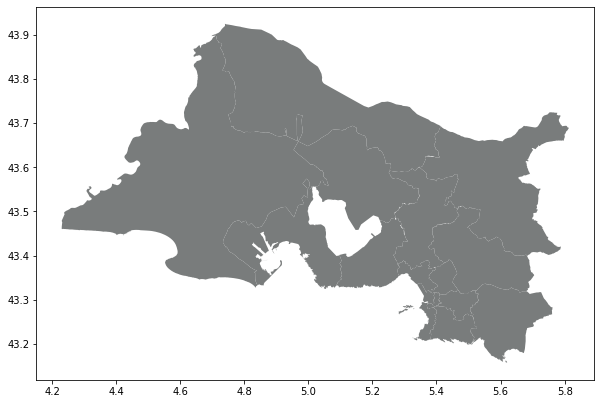

In [13]:
fig, ax=plt.subplots(figsize=(10,10))
bdr.plot(ax=ax, color="#797c7c", linewidth=.7);

Et enfin exporter ce fichier géographique tout prêt pour la cartographie :

In [14]:
bdr.to_file(r"data/bdr.json", driver="GeoJSON")

C:\Users\Rapha\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
